In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
file_path = "combined.csv"  # Update this path if needed
df = pd.read_csv(file_path)

In [3]:
# Feature Engineering: Compute LW_RW_DIFF if not already present
if 'LW_RW_DIFF' not in df.columns:
    # Total Fuel in Left and Right Wing
    df['TOTAL_FUEL_LW'] = (df['VALUE_FUEL_QTY_LXT'] + df['VALUE_FUEL_QTY_FT1'] + df['VALUE_FUEL_QTY_FT2'])
    df['TOTAL_FUEL_RW'] = (df['VALUE_FUEL_QTY_RXT'] + df['VALUE_FUEL_QTY_FT3'] + df['VALUE_FUEL_QTY_FT4'])

    # Fuel Difference
    df['LW_RW_DIFF'] = (df['TOTAL_FUEL_LW'] - df['TOTAL_FUEL_RW']).abs()

In [4]:
# Define function to determine leaks
def detect_leak(df, threshold=1500, probability=0.25):
    """
    Function to assign leak labels based on LW_RW_DIFF threshold and probability.
    
    Parameters:
    df (DataFrame): Input dataset
    threshold (int): Fuel difference threshold to consider leak
    probability (float): Probability of assigning a leak when threshold is exceeded
    
    Returns:
    Series: Column with leak labels (0 or 1)
    """
    return np.where((df['LW_RW_DIFF'] > threshold) & (np.random.rand(len(df)) < probability), 1, 0)

In [5]:
# Apply leak detection function
df['LEAK'] = detect_leak(df)

C:\Users\gabri\AppData\Local\Temp\ipykernel_20288\254467267.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='LEAK', data=df, palette='coolwarm')


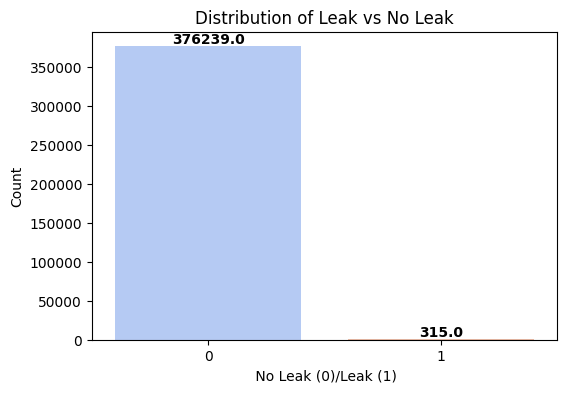

In [6]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(6,4))
ax = sns.countplot(x='LEAK', data=df, palette='coolwarm')
plt.title("Distribution of Leak vs No Leak")
plt.xlabel(" No Leak (0)/Leak (1)")
plt.ylabel("Count")

# Add total values above bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.show()

In [7]:
# Display summary statistics
print("Summary Statistics for LEAK Column:")
print(df['LEAK'].describe())

Summary Statistics for LEAK Column:
count    376554.000000
mean          0.000837
std           0.028911
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: LEAK, dtype: float64


In [8]:
# Display value counts (distribution of leaks vs no leaks with percentages)
leak_counts = df['LEAK'].value_counts()
leak_percentages = df['LEAK'].value_counts(normalize=True) * 100

print(f"\nLeak Distribution at Leak Probability of 30%:")
print(pd.DataFrame({'Count': leak_counts, 'Percentage': leak_percentages.round(2)}))


Leak Distribution at Leak Probability of 30%:
       Count  Percentage
LEAK                    
0     376239       99.92
1        315        0.08


In [9]:
# Display dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376554 entries, 0 to 376553
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   UTC_TIME                   376554 non-null  object 
 1   FUEL_USED_2                376554 non-null  float64
 2   FUEL_USED_3                376554 non-null  float64
 3   FUEL_USED_4                376554 non-null  float64
 4   FW_GEO_ALTITUDE            376554 non-null  float64
 5   VALUE_FOB                  376554 non-null  float64
 6   VALUE_FUEL_QTY_CT          376554 non-null  float64
 7   VALUE_FUEL_QTY_FT1         376554 non-null  float64
 8   VALUE_FUEL_QTY_FT2         376554 non-null  float64
 9   VALUE_FUEL_QTY_FT3         376554 non-null  float64
 10  VALUE_FUEL_QTY_FT4         376554 non-null  float64
 11  VALUE_FUEL_QTY_LXT         376554 non-null  float64
 12  VALUE_FUEL_QTY_RXT         376554 non-null  float64
 13  FLIGHT_PHASE_COUNT         37

In [10]:
# Load an MSN file (change file path as needed)
#msn_file_path = "msn_10_fuel_leak_signals_preprocessed.csv"  # Update with the correct file path
#msn_df = pd.read_csv(msn_file_path,delimiter=";")

# Extract column names from the MSN file
#msn_columns = msn_df.columns.tolist()

# Ensure "LEAK" is included in df
#msn_columns.append("LEAK")

# Filter df to only keep columns that exist in the MSN file + "LEAK"
#df_filtered = df[msn_columns]

# Display the new structure of df
#print(f"Filtered df shape: {df_filtered.shape}")
#print(f"Columns in filtered df: {list(df_filtered.columns)}")

## Model Setups

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def split_train_test(df, leak_column="LEAK", test_size=0.15):
    """
    Splits the dataset into train and test sets while maintaining the chronological order.
    Ensures the same proportion of leaks in train and test sets.
    """
    df = df.sort_values(by="UTC_TIME")  # Sort by time to prevent data leakage

    split_idx = int(len(df) * (1 - test_size))  # Compute split index
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]

    # Count the number of leaks in each dataset
    train_leak_count = train_df['LEAK'].sum()
    test_leak_count = test_df['LEAK'].sum()
    total_leak_count = df['LEAK'].sum()
    # Compute expected leak split (should be 75%-25%)
    expected_train_leaks = int(total_leak_count * 0.85)
    expected_test_leaks = total_leak_count - expected_train_leaks

    # Display class distributions
    print(f"Total Leak Count: {total_leak_count}")
    print(f"Train set leak rate: {100 * train_df[leak_column].mean():.4f}% == Training Leak Count: {train_leak_count} (Expected: {expected_train_leaks}) ")
    print(f"Test set leak rate: {100 * test_df[leak_column].mean():.4f}% == Testing Leak Count: {test_leak_count} (Expected: {expected_test_leaks})")
    print(f"Training Data Shape: {train_df.shape}, Testing Data Shape: {test_df.shape}")

    return train_df, test_df

# Apply split
train_df, test_df = split_train_test(df)


Total Leak Count: 315
Train set leak rate: 0.0781% == Training Leak Count: 250 (Expected: 267) 
Test set leak rate: 0.1151% == Testing Leak Count: 65 (Expected: 48)
Training Data Shape: (320070, 35), Testing Data Shape: (56484, 35)


Autoencoder

In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
import numpy as np

# Filter out the entries with leaks from training data
train_data = train_df[train_df['LEAK'] == 0].drop(columns=['LEAK'])

# Identify numerical columns and scale only those
numerical_cols = train_data.select_dtypes(include=[np.number]).columns
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data[numerical_cols])

# Define the autoencoder model architecture
input_dim = train_data_scaled.shape[1]  # Number of features
encoding_dim = 14  # Dimension of the encoded representation

# Input layer
input_layer = Input(shape=(input_dim,))
# Encoder layers
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
# Decoder layers
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder on the scaled training data
autoencoder.fit(train_data_scaled, train_data_scaled,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                verbose=1)

# Prepare the test data by selecting only numerical columns and scaling
test_data = test_df[numerical_cols]
test_data_scaled = scaler.transform(test_data)

# Get the reconstruction loss (MSE) on the test data
reconstructions = autoencoder.predict(test_data_scaled)
mse = np.mean(np.power(test_data_scaled - reconstructions, 2), axis=1)

# Determine the threshold for anomaly detection based on 95th percentile of MSE
threshold = np.percentile(mse, 95)

# Detect anomalies based on the threshold
test_df = test_df.copy()  # Avoid SettingWithCopyWarning
test_df['reconstruction_error'] = mse
test_df['anomaly'] = test_df['reconstruction_error'] > threshold

# Calculate evaluation metrics: Confusion Matrix, Accuracy, Precision, Recall, F1 Score
y_true = test_df['LEAK']  # True labels
y_pred = test_df['anomaly'].astype(int)  # Predicted labels (0 or 1)

conf_matrix = confusion_matrix(y_true, y_pred)  # Confusion Matrix
accuracy = accuracy_score(y_true, y_pred)  # Accuracy
precision = precision_score(y_true, y_pred, zero_division=0)  # Precision
recall = recall_score(y_true, y_pred, zero_division=0)  # Recall
f1 = f1_score(y_true, y_pred, zero_division=0)  # F1 Score

# Print the evaluation results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Epoch 1/100
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0382 - val_loss: 0.0019
Epoch 2/100
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 8s 967us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 3/100
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 4/100
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/100
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/100
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 8.6351e-04 - val_loss: 0.0011
Epoch 7/100
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 8.3755e-04 - val_loss: 0.0012
Epoch 8/100
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 8.1042e-04 - val_loss: 0.0011
Epoch 9/100
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 7.9379e-04 - val_loss: 0.0011
Epoch 10/100
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 7.8579e-04 - val_loss: 0.0011
Epoch 11/100
7996/7996 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 7.7150e-04 - val_

Isolation Forest

In [16]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Remove unwanted columns from training and test data
test_df = test_df.drop(columns=['reconstruction_error'], errors='ignore')
train_df = train_df.drop(columns=['reconstruction_error'], errors='ignore')

# Extract numerical features for training and testing
train_x = train_df.select_dtypes(include=[np.number]).drop(columns=['LEAK'])
test_x = test_df.select_dtypes(include=[np.number]).drop(columns=['LEAK'])

# Create an Isolation Forest model
isolation_forest = IsolationForest(contamination=0.025, random_state=42)

# Fit the model on training data
isolation_forest.fit(train_x)

# Predict anomalies
train_x_predictions = isolation_forest.predict(train_x)
test_x_predictions = isolation_forest.predict(test_x)

# Convert predictions to binary labels (-1 indicates an anomaly)
train_x_predictions = (train_x_predictions == -1).astype(int)
test_x_predictions = (test_x_predictions == -1).astype(int)

# Print the confusion matrix for training data
cm_train = confusion_matrix(train_df['LEAK'], train_x_predictions)
print("Training Confusion Matrix:\n", cm_train)

# Print the confusion matrix for test data
cm_test = confusion_matrix(test_df['LEAK'], test_x_predictions)
print("Testing Confusion Matrix:\n", cm_test)

# Print precision, recall, accuracy, and F1 score
accuracy = accuracy_score(test_df['LEAK'], test_x_predictions)
recall = recall_score(test_df['LEAK'], test_x_predictions, zero_division=0)
precision = precision_score(test_df['LEAK'], test_x_predictions, zero_division=0)
f1 = f1_score(test_df['LEAK'], test_x_predictions, zero_division=0)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')


Training Confusion Matrix:
 [[311901   7919]
 [   167     83]]
Testing Confusion Matrix:
 [[54823  1596]
 [   65     0]]
Accuracy: 0.9705934423907655
Recall: 0.0
Precision: 0.0
F1 Score: 0.0


XGBoost

In [23]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

# Feature selection for XGBoost
drop_columns = ['UTC_TIME', 'FLIGHT_ID', 'MSN']
selected_features = [
    'VALUE_FOB', 'EXPECTED_FOB', 'FOB_DIFFERENCE', 'FOB_CHANGE',
    'START_FOB_VS_FOB_FUELUSED', 'TOTAL_FUEL_USED', 'FLIGHT_PHASE_COUNT', 'LEAK'
]

# Ensure rolling features exist before selecting features
train_df['VALUE_FOB_mean'] = train_df['VALUE_FOB'].rolling(window=10).mean()
train_df['VALUE_FOB_mean'] = train_df['VALUE_FOB_mean'].fillna(train_df['VALUE_FOB_mean'].mean())
train_df['lagged'] = train_df['VALUE_FOB'].shift(1).fillna(train_df['VALUE_FOB'].mean())
test_df['VALUE_FOB_mean'] = test_df['VALUE_FOB'].rolling(window=10).mean()
test_df['VALUE_FOB_mean'] = test_df['VALUE_FOB_mean'].fillna(test_df['VALUE_FOB_mean'].mean())
test_df['lagged'] = test_df['VALUE_FOB'].shift(1).fillna(test_df['VALUE_FOB'].mean())

# Add rolling features to selected features
selected_features.extend(['VALUE_FOB_mean', 'lagged'])

xgboostdata = train_df[selected_features]

# Ensure test set contains all necessary features
X_train = xgboostdata.drop(columns=['LEAK'])
y_train = xgboostdata['LEAK']
X_test = test_df[selected_features].drop(columns=['LEAK'], errors='ignore')
y_test = test_df['LEAK']

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost classifier
xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_train)

# Predictions
train_x_predictions = xgb.predict(X_train_scaled)
test_x_predictions = xgb.predict(X_test_scaled)

# Evaluate performance
cm_train = confusion_matrix(y_train, train_x_predictions)
cm_test = confusion_matrix(y_test, test_x_predictions)

accuracy = accuracy_score(y_test, test_x_predictions)
recall = recall_score(y_test, test_x_predictions, zero_division=0)
precision = precision_score(y_test, test_x_predictions, zero_division=0)
f1 = f1_score(y_test, test_x_predictions, zero_division=0)

print("Training Confusion Matrix:\n", cm_train)
print("Testing Confusion Matrix:\n", cm_test)
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

# Feature importance
feature_importances = xgb.feature_importances_
features = X_train.columns
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)

# Hyperparameter tuning
tuning_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
}

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=tuning_params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict with the best model
train_x_predictions = grid_search.best_estimator_.predict(X_train_scaled)
test_x_predictions = grid_search.best_estimator_.predict(X_test_scaled)

# Final evaluation
cm_train = confusion_matrix(y_train, train_x_predictions)
cm_test = confusion_matrix(y_test, test_x_predictions)
accuracy = accuracy_score(y_test, test_x_predictions)
recall = recall_score(y_test, test_x_predictions, zero_division=0)
precision = precision_score(y_test, test_x_predictions, zero_division=0)
f1 = f1_score(y_test, test_x_predictions, zero_division=0)

print("Final Training Confusion Matrix:\n", cm_train)
print("Final Testing Confusion Matrix:\n", cm_test)
print(f'Final Accuracy: {accuracy}')
print(f'Final Recall: {recall}')
print(f'Final Precision: {precision}')
print(f'Final F1 Score: {f1}')

# Print final feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)


c:\Users\gabri\anaconda3\Lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:41:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Confusion Matrix:
 [[319817      3]
 [    54    196]]
Testing Confusion Matrix:
 [[56419     0]
 [   65     0]]
Accuracy: 0.9988492316408186
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
                     Feature  Importance
1               EXPECTED_FOB    0.187690
2             FOB_DIFFERENCE    0.156515
5            TOTAL_FUEL_USED    0.141867
8                     lagged    0.134583
4  START_FOB_VS_FOB_FUELUSED    0.132620
0                  VALUE_FOB    0.124108
7             VALUE_FOB_mean    0.087646
3                 FOB_CHANGE    0.034971
6         FLIGHT_PHASE_COUNT    0.000000
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


c:\Users\gabri\anaconda3\Lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:29:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.5}
Best Score: 0.9992189208610617
Final Training Confusion Matrix:
 [[319820      0]
 [   250      0]]
Final Testing Confusion Matrix:
 [[56419     0]
 [   65     0]]
Final Accuracy: 0.9988492316408186
Final Recall: 0.0
Final Precision: 0.0
Final F1 Score: 0.0
                     Feature  Importance
8                     lagged    0.224856
0                  VALUE_FOB    0.162005
5            TOTAL_FUEL_USED    0.144360
1               EXPECTED_FOB    0.135601
7             VALUE_FOB_mean    0.130420
2             FOB_DIFFERENCE    0.116259
4  START_FOB_VS_FOB_FUELU

In [21]:
train_df.columns

Index(['UTC_TIME', 'FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4',
       'FW_GEO_ALTITUDE', 'VALUE_FOB', 'VALUE_FUEL_QTY_CT',
       'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3',
       'VALUE_FUEL_QTY_FT4', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT',
       'FLIGHT_PHASE_COUNT', 'FUEL_USED_1', 'Flight', 'MSN', 'NEW_FLIGHT',
       'FLIGHT_INSTANCE', 'FLIGHT_ID', 'START_FOB', 'TOTAL_FUEL_USED',
       'EXPECTED_FOB', 'FOB_DIFFERENCE', 'FOB_CHANGE', 'EXPECTED_FOB_CHANGE',
       'FUEL_LEAK_RATE', 'TOTAL_FUEL_LW', 'TOTAL_FUEL_RW', 'LW_RW_DIFF',
       'FUEL_IN_TANKS', 'CALC_VALUE_FOB_DIFF', 'START_FOB_VS_FOB_FUELUSED',
       'ALTITUDE_DIFF', 'LEAK'],
      dtype='object')

LSTM

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed

# Identify numerical columns and scale only those
numerical_cols = train_df.select_dtypes(include=[np.number]).columns
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_df[numerical_cols])
test_data_scaled = scaler.transform(test_df[numerical_cols])

# Reshape data for LSTM (samples, timesteps, features)
time_steps = 10  # Number of time steps for LSTM input
train_data_reshaped = train_data_scaled.reshape((train_data_scaled.shape[0], 1, train_data_scaled.shape[1]))
test_data_reshaped = test_data_scaled.reshape((test_data_scaled.shape[0], 1, test_data_scaled.shape[1]))

# Define LSTM Autoencoder model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(1, train_data_scaled.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(1),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(train_data_scaled.shape[1]))
])

model.compile(optimizer='adam', loss='mse')

# Train the LSTM Autoencoder
model.fit(train_data_reshaped, train_data_reshaped,
          epochs=50,
          batch_size=64,
          validation_split=0.2,
          shuffle=True,
          verbose=1)

# Get reconstruction loss (MSE) on the test data
reconstructions = model.predict(test_data_reshaped)
mse = np.mean(np.power(test_data_reshaped - reconstructions, 2), axis=(1, 2))

# Determine anomaly threshold based on 95th percentile
threshold = np.percentile(mse, 95)

# Detect anomalies based on the threshold
test_df = test_df.copy()
test_df['reconstruction_error'] = mse
test_df['anomaly'] = test_df['reconstruction_error'] > threshold

# Evaluation metrics
y_true = test_df['LEAK']
y_pred = test_df['anomaly'].astype(int)

conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Print evaluation results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Epoch 1/50


c:\Users\gabri\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4001/4001 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.0217 - val_loss: 0.0012
Epoch 2/50
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 3/50
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 8.6766e-04 - val_loss: 0.0018
Epoch 4/50
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 6.9316e-04 - val_loss: 0.0017
Epoch 5/50
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 5.9478e-04 - val_loss: 0.0019
Epoch 6/50
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 5.4250e-04 - val_loss: 0.0018
Epoch 7/50
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.9517e-04 - val_loss: 0.0019
Epoch 8/50
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.5838e-04 - val_loss: 0.0023
Epoch 9/50
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.3946e-04 - val_loss: 0.0022
Epoch 10/50
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.1074e-04 - val_loss: 0.0024
Epoch 11/50
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 3.9339e-04 - val_loss: 0